This notebook covers the concepts underlying design efficiency.

In order to examine the factors that affect efficiency, we need to be able to generate experimental designs that vary in their timing and correlation between regressors. Let's first create a function that can generate such designs for us.

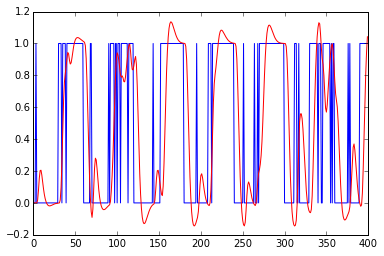

In [1]:
import os
import numpy
%matplotlib inline
from mkdesign import create_design_singlecondition
import matplotlib.pyplot as plt
from spm_hrf import spm_hrf
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor

# the "blockiness" argument controls how block-y the design is
# from 1( pure block) to 0 (pure random)
d,design=create_design_singlecondition(blockiness=0.9)
plt.axis([0,400,-0.2,1.2])
plt.plot(d)

tr=1.0


regressor,_=compute_regressor(design,'spm',numpy.arange(0,len(d)))
plt.plot(regressor,color='red')


Now that we have our design, let's generate some synthetic data.  We will generate AR1 noise to add to the data; this is not a perfect model of the autocorrelation in fMRI, but it's at least a start towards realistic noise.


In [2]:
from statsmodels.tsa.arima_process import arma_generate_sample

ar1_noise=arma_generate_sample([1,0.3],[1,0.],len(regressor))
beta=4
y=regressor.T*beta + ar1_noise
print y.shape

(1, 400)


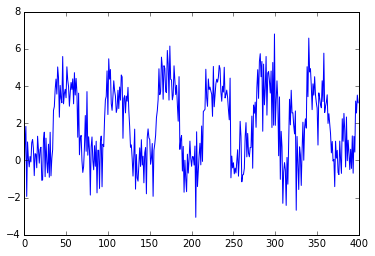

In [3]:
plt.plot(y.T)

Now let's fit the general linear model to these data. We will ignore serial autocorrelation for now.

(-0.5, 1.5, 400.0, -50.0)

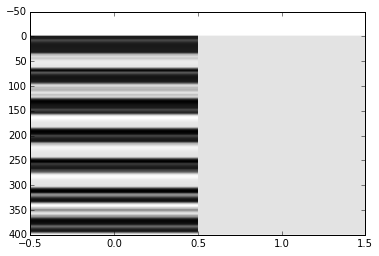

In [4]:
X=numpy.vstack((regressor.T,numpy.ones(y.shape))).T
plt.imshow(X,interpolation='nearest',cmap='gray')
plt.axis('auto')

(400, 2)


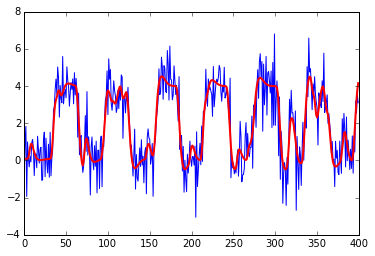

In [5]:
beta_hat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(y.T)
y_est=X.dot(beta_hat)
plt.plot(y.T,color='blue')
plt.plot(y_est,color='red',linewidth=2)
print X.shape

Now let's make a function to repeatedly generate data and fit the model.

In [6]:
def generate_and_fit(X,beta=[4,10],c=[1,0]):
    assert len(c)==X.shape[1]
    ar1_noise=arma_generate_sample([1,0.3],[1,0.],X.shape[0])
    y=X.dot(beta) + ar1_noise.T
    beta_hat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    resid=y - X.dot(beta_hat)
    c=numpy.array(c)
    sigma2_hat=c.dot(numpy.linalg.inv(X.T.dot(X))).dot(c)*(resid.dot(resid)/(X.shape[0] - X.shape[1] - 1))
    return beta_hat,sigma2_hat
    

Now let's write a simulation that creates datasets with varying levels of blockiness, runs the previous function 1000 times for each level, and computes the variability of the estimates

In [7]:
nruns=1000
blockiness_vals=numpy.arange(0,1.1,0.1)
stdvals_blockiness=numpy.zeros((2,len(blockiness_vals)))
meansigmahat_blockiness=numpy.zeros(len(blockiness_vals))

for b in range(len(blockiness_vals)):
    beta_hats=numpy.zeros((2,nruns))
    sigma_hats=numpy.zeros(nruns)
    
    for i in range(nruns):
        d_sim,design_sim=create_design_singlecondition(blockiness=blockiness_vals[b])
        regressor_sim,_=compute_regressor(design_sim,'spm',numpy.arange(0,len(d_sim)))
        X=numpy.vstack((regressor_sim.T,numpy.ones(y.shape))).T
        beta_hats[:,i],sigma_hats[i]=generate_and_fit(X)
    stdvals_blockiness[:,b]=numpy.var(beta_hats,1)
    meansigmahat_blockiness[b]=numpy.mean(sigma_hats)

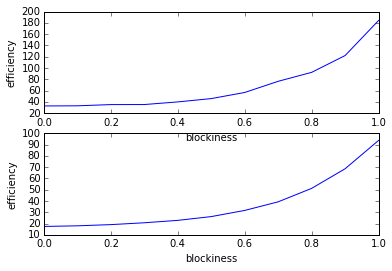

In [8]:
plt.subplot(211)
plt.plot(blockiness_vals,1./stdvals_blockiness[0,:])
plt.xlabel('blockiness')
plt.ylabel('efficiency')

plt.subplot(212)
plt.plot(blockiness_vals,1./meansigmahat_blockiness)
plt.xlabel('blockiness')
plt.ylabel('efficiency')



Now let's do a similar simulation looking at the effects of varying block length between 10 seconds and 120 seconds (in steps of 10)

In [9]:
nruns=1000
blocklenvals=numpy.arange(10,120,5)
stdvals_blocklen=numpy.zeros((2,len(blocklenvals)))
meansigmahat_blocklen=numpy.zeros(len(blocklenvals))

for b in range(len(blocklenvals)):
    beta_hats=numpy.zeros((2,nruns))
    sigma_hats=numpy.zeros(nruns)
    for i in range(nruns):
        d_sim,design_sim=create_design_singlecondition(blocklength=blocklenvals[b],blockiness=1.)
        regressor_sim,_=compute_regressor(design_sim,'spm',numpy.arange(0,len(d_sim)))
        X=numpy.vstack((regressor_sim.T,numpy.ones(y.shape))).T
        beta_hats[:,i],sigma_hats[i]=generate_and_fit(X)
    stdvals_blocklen[:,b]=numpy.std(beta_hats,1)
    meansigmahat_blocklen[b]=numpy.mean(sigma_hats)

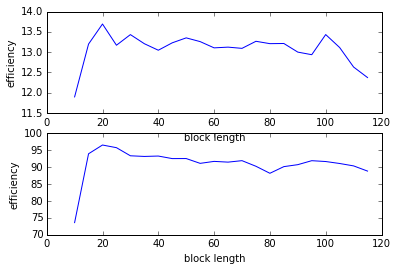

In [10]:
plt.subplot(211)
plt.plot(blocklenvals,1./stdvals_blocklen[0,:])
plt.xlabel('block length')
plt.ylabel('efficiency')

plt.subplot(212)
plt.plot(blocklenvals,1./meansigmahat_blocklen)
plt.xlabel('block length')
plt.ylabel('efficiency')



Now let's look at the effects of correlation between regressors. We first need to create a function to generate a design with two conditions where we can control the correlation between them.

In [16]:
from mkdesign import create_design_twocondition

d,des1,des2=create_design_twocondition(correlation=1.0)
regressor1,_=compute_regressor(des1,'spm',numpy.arange(0,d.shape[0]))
regressor2,_=compute_regressor(des2,'spm',numpy.arange(0,d.shape[0]))

X=numpy.vstack((regressor1.T,regressor2.T,numpy.ones(y.shape))).T

In [17]:
nruns=500
corr_vals=numpy.arange(0,1.1,0.1)
stdvals_corr=numpy.zeros((3,len(corr_vals)))
corrvals=numpy.zeros(len(corr_vals))
meansigmahat_corr=numpy.zeros(len(corr_vals))
for b in range(len(corr_vals)):
    beta_hats=numpy.zeros((3,nruns))
    sigma_hats=numpy.zeros(nruns)
    corrs=numpy.zeros(nruns)
    for i in range(nruns):
        d_sim,des1_sim,des2_sim=create_design_twocondition(correlation=corr_vals[b])
        regressor1_sim,_=compute_regressor(des1_sim,'spm',numpy.arange(0,d_sim.shape[0]))
        regressor2_sim,_=compute_regressor(des2_sim,'spm',numpy.arange(0,d_sim.shape[0]))
        X=numpy.vstack((regressor1_sim.T,regressor2_sim.T,numpy.ones(y.shape))).T
        # use contrast of first regressor
        beta_hats[:,i],sigma_hats[i]=generate_and_fit(X,[3,5,10],c=[1,0,0])
        corrs[i]=numpy.corrcoef(X.T)[0,1]
    stdvals_corr[:,b]=numpy.std(beta_hats,1)
    corrvals[b]=numpy.mean(corrs)
    meansigmahat_corr[b]=numpy.mean(sigma_hats)

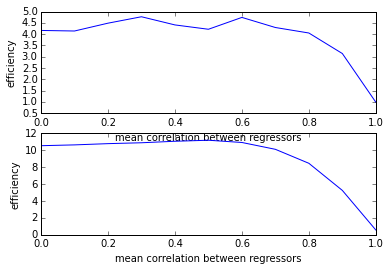

In [19]:
plt.subplot(211)
plt.plot(corr_vals,1./stdvals_corr[0,:])
plt.xlabel('mean correlation between regressors')
plt.ylabel('efficiency')

plt.subplot(212)
plt.plot(corr_vals,1./meansigmahat_corr)
plt.xlabel('mean correlation between regressors')
plt.ylabel('efficiency')



Now let's look at efficiency of estimation of the shape of the HRF, rather than detection of the activation effect.  This requires that we use a finite impulse response (FIR) model.

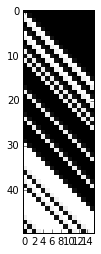

In [21]:
d,design=create_design_singlecondition(blockiness=0.0)
regressor,_=compute_regressor(design,'fir',numpy.arange(0,len(d)),fir_delays=numpy.arange(0,16))
plt.imshow(regressor[:50,:],interpolation='nearest',cmap='gray')


Now let's simulate the FIR model, and estimate the variance of the fits.

In [37]:


print fir_betas.shape
print regressor.shape
print X.shape

(16,)
(400, 16)
(400, 17)


In [73]:
def generate_and_fit_trace(X,beta=None,signal=2):
    """return trace of covariance matrix for all but last regressor (which is the mean)"""
    if not beta:
        beta=numpy.hstack((signal*spm_hrf(1,oversampling=1)[:X.shape[1]-1],10))
    ar1_noise=arma_generate_sample([1,0.3],[1,0.],X.shape[0])
    y=X.dot(beta) + ar1_noise.T
    beta_hat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    resid=y - X.dot(beta_hat)
    sigma2_hat=numpy.trace(numpy.linalg.inv(X[:,:-1].T.dot(X[:,:-1])))*(resid.dot(resid)/(X.shape[0] - X.shape[1] - 1))
    return beta_hat,sigma2_hat
    
    
nruns=100
blockiness_vals=numpy.arange(0,1.1,0.1)
stdvals_blockiness=numpy.zeros((17,len(blockiness_vals)))
betavals_blockiness=numpy.zeros((17,len(blockiness_vals)))
meanstd_blockiness=numpy.zeros(len(blockiness_vals))

fir_betas=numpy.hstack((10*spm_hrf(1,oversampling=1)[:16],10))

for b in range(len(blockiness_vals)):
    beta_hats=numpy.zeros((17,nruns))
    sigma_hats=numpy.zeros(nruns)
    for i in range(nruns):
        d_sim,design_sim=create_design_singlecondition(blockiness=blockiness_vals[b])
        regressor_sim,_=compute_regressor(design_sim,'fir',
                            numpy.arange(0,len(d_sim)),fir_delays=numpy.arange(0,16))
        X=numpy.vstack((regressor_sim.T,numpy.ones(regressor_sim.shape[0]))).T
        contrast=numpy.ones(X.shape[1])
        contrast[-1]=0
        beta_hats[:,i],sigma_hats[i]=generate_and_fit_trace(X)
        
    stdvals_blockiness[:,b]=numpy.std(beta_hats,1)
    betavals_blockiness[:,b]=numpy.mean(beta_hats,1)
    meanstd_blockiness[b]=numpy.mean(sigma_hats)

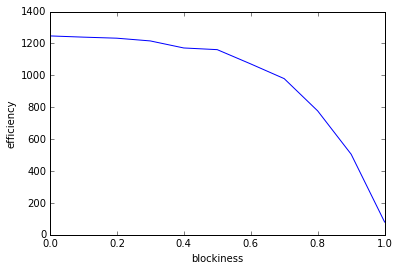

In [71]:
plt.plot(blockiness_vals,1./meanstd_blockiness)
plt.xlabel('blockiness')
plt.ylabel('efficiency')

Exercise: write a function to generate random designs, and then do this a large number of times, each time estimating the efficiency.  Then plot the histogram of efficiencies. 